In [7]:
import torch
from torch import nn
from torch.utils.data import dataloader
from torchvision.transforms import v2
from skimage import color
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [8]:
from torch import zeros_like, cat
from torch.utils.data import Dataset
from torchvision.datasets import Flowers102
from typing import Any
from PIL import Image
from random import randint
import os


from src.Datasets import CocoDataset


root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((128,128), antialias=True),
	# v2.Normalize(((-126.,-126.,0.)), ((256.,256.,100.)))
])

UnNormalize = v2.Compose([
	v2.Normalize((0.,0.,0.), (1/256.,1/256.,1/100.)),
	v2.Normalize((126.,126.,0.), (1.,1.,1.))
])

train_dataset = CocoDataset(root=root_dir, split="train", add_pixels=True, percent=0.25,transform=transform)
test_dataset = CocoDataset(root=root_dir, split="test", add_pixels=True, percent=0.25, transform=transform)

print(train_dataset.get_info())
print(test_dataset.get_info())

Dataset: ./ressources/coco_dataset/train 	Number of images: 40670
Dataset: ./ressources/coco_dataset/test 	Number of images: 5000


Images shapes :torch.Size([3, 128, 128]) (input)
Images shapes :torch.Size([3, 128, 128]) (target)


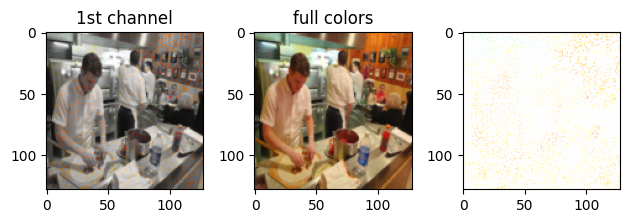

In [9]:
def tensorToImg(tensor:torch.Tensor):
	if len(tensor.shape) == 4:
		tensor = tensor.squeeze(0)
	return tensor.moveaxis(0,2).detach().cpu().numpy()


img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input)")
size = img1[0, ...].unsqueeze(0).shape
l_channel = torch.full(size, 100)
a_channel = img1[1, ...].unsqueeze(0)
b_channel = img1[2, ...].unsqueeze(0)

img_pixel = torch.cat((l_channel, a_channel, b_channel), dim=0)
# img1 = UnNormalize(img1)
# img2 = UnNormalize(img2)
fig = plt.figure()
ax1, ax2, ax3 = fig.subplots(1, 3)

ax1.imshow(color.lab2rgb(tensorToImg(img1)))
ax1.set_title("1st channel")
ax3.imshow(color.lab2rgb(tensorToImg(img_pixel)))
# img_colored = torch.cat((img1[0].unsqueeze(0), img2), dim=0)
print(f"Images shapes :{img2.shape} (target)")

ax2.imshow(color.lab2rgb(tensorToImg(img2)))
ax2.set_title("full colors")
plt.tight_layout()

In [10]:
from tqdm import tqdm

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer, verbose = True):
	size = len(dataloader.dataset)
	model = model.to(device)
	model.train()
	train_loss = 0

	for (X, y) in (tqdm(dataloader, desc=train_loss) if verbose else dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		train_loss += loss.item()

	return train_loss / size

# Test loop
def test_loop(dataloader, model, loss_fn, verbose = True):
	size = len(dataloader.dataset)
	model = model.to(device)
	model.eval()
	test_loss = 0

	with torch.no_grad():
		for (X, y) in (tqdm(dataloader) if verbose else dataloader):
			X = X.to(device)
			y = y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
	return test_loss / size

In [11]:
def select_n_random(data, n=3):
    perm = torch.randperm(len(data))
    listData = [data[perm[i]] for i in range(n)]
    return listData

def plot_images_colorization(model, data):
    model.eval()
    
    fig = plt.figure()
    axes = fig.subplots(len(data), 3)
    for i, (ax1, ax2, ax3) in enumerate(axes):
        img1, img2 = data[i]
        img1 = img1.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img1).to(device)
        ax1.imshow(color.lab2rgb(img1[0].moveaxis(0, 2).cpu()))
        # img1 = img1[0][0].unsqueeze(0)
        # # out = torch.cat((img1, out[0]), dim=0).to(device)
        # img1 = img1.cpu()
       
        ax2.imshow(color.lab2rgb(out[0].detach().moveaxis(0, 2).cpu()))
        # img2 = torch.cat((img1, img2), dim=0)
        ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
    return fig

# Overfit

In [12]:
from src.Models import NetworkColorWithScribble
# Define the model
model = NetworkColorWithScribble()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Dataloaders


overfit_dataset = [train_dataset[i] for i in range(10)]
train_loader = dataloader.DataLoader(overfit_dataset, shuffle=True, batch_size=1)

In [14]:
a,_ = overfit_dataset[0]
print(a.shape)

torch.Size([3, 128, 128])


Done!


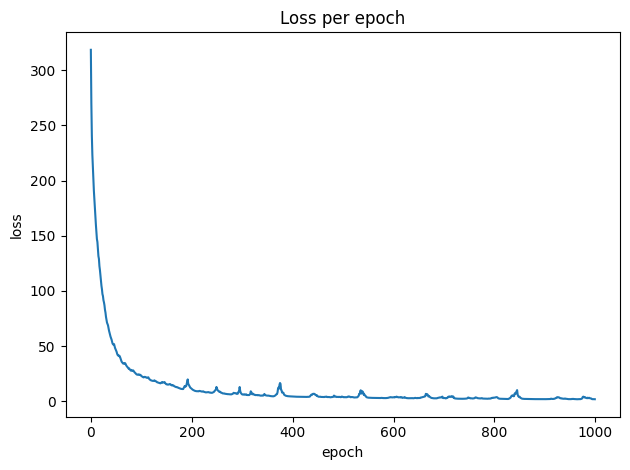

In [15]:
# Set the number of epochs
num_epochs = 1000

tot_loss = []
for t in range(num_epochs):
    tot_loss.append(train_loop(train_loader, model, criterion, optimizer, verbose=False))
        
print("Done!")

plt.plot(tot_loss)
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

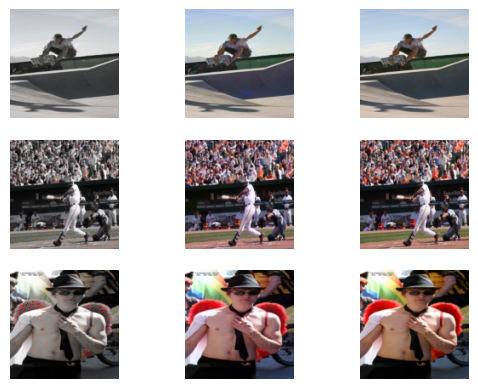

In [16]:
data = select_n_random(overfit_dataset, n=3)

fig = plot_images_colorization(model, data)

# Train

In [17]:

# Define the model
model = NetworkColorWithScribble()



In [18]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Dataloaders

n_train = 10000
n_test = 1000
train_dataset = [train_dataset[i] for i in range(n_train)]
test_dataset = [test_dataset[i] for i in range(n_test)]

In [ ]:
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=False, batch_size=64)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set the number of epochs
num_epochs = 30

train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, verbose=True)
    test_loss = test_loop(test_loader, model, criterion, verbose=False)
    writer.add_scalar("Loss/train", train_loss, t)
    writer.add_scalar("Loss/test", test_loss, t)
    if (t+1) % 1 == 0:
        data = select_n_random(train_dataset, n=4)
        writer.add_figure('grey/colorized/real',
                            plot_images_colorization(model,data),
                            global_step=t+1)
        writer.flush()
        

print("Done!")
writer.close()

Epoch 1 -------------------------------


  1%|▏         | 2/157 [00:00<00:08, 19.16it/s]

100%|██████████| 157/157 [00:07<00:00, 19.98it/s]


Epoch 2 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.01it/s]


Epoch 3 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.52it/s]


Epoch 4 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.36it/s]


Epoch 5 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.84it/s]


Epoch 6 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.02it/s]


Epoch 7 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.47it/s]


Epoch 8 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.71it/s]


Epoch 9 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.64it/s]


Epoch 10 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 19.99it/s]


Epoch 11 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.13it/s]


Epoch 12 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.55it/s]


Epoch 13 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.34it/s]


Epoch 14 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.29it/s]


Epoch 15 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.18it/s]


Epoch 16 -------------------------------


100%|██████████| 157/157 [00:08<00:00, 18.99it/s]


Epoch 17 -------------------------------


100%|██████████| 157/157 [00:09<00:00, 15.97it/s]


Epoch 18 -------------------------------


100%|██████████| 157/157 [00:08<00:00, 18.46it/s]


Epoch 19 -------------------------------


100%|██████████| 157/157 [00:08<00:00, 17.97it/s]


Epoch 20 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Epoch 21 -------------------------------


100%|██████████| 157/157 [00:08<00:00, 19.13it/s]


Epoch 22 -------------------------------


100%|██████████| 157/157 [00:09<00:00, 16.93it/s]


Epoch 23 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Epoch 24 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.09it/s]


Epoch 25 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.06it/s]


Epoch 26 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.33it/s]


Epoch 27 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.22it/s]


Epoch 28 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.28it/s]


Epoch 29 -------------------------------


100%|██████████| 157/157 [00:07<00:00, 20.03it/s]


Epoch 30 -------------------------------


100%|██████████| 157/157 [00:08<00:00, 19.44it/s]


Done!


In [ ]:
test_dataset = CocoDataset(root=root_dir, split="test", add_pixels=True, percent=0.1
                           , transform=transform)

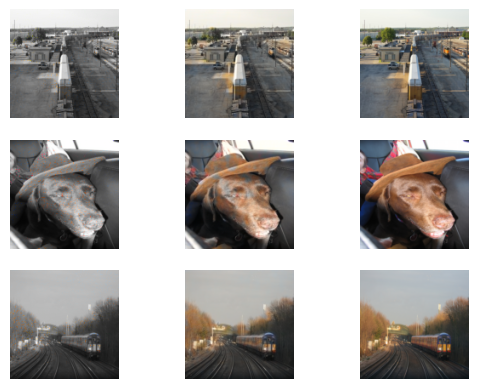

In [ ]:

# model = NetworkColorWithScribble()
# model.load_state_dict(torch.load('./model.pth'))
# model.to(device)
data = select_n_random(test_dataset, n=3)

fig = plot_images_colorization(model, data)

In [ ]:
from src.Models import save_model



save = False

if save:
    torch.save(model.state_dict(), "./model25%.pth")

In [ ]:
model = NetworkColorWithScribble()
model.load_state_dict(torch.load('./model1%.pth'))
model.to(device)

NetworkColorWithScribble(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), dilation=(2, 2))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), dilation=(2, 2))